In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm, sem
from tqdm import tqdm
from utils import *

np.random.seed(103)

In [2]:
def gen_data(n, d, std_in, std_out, beta, R, B):
    X = (B[:, 1] - B[:, 0]) * np.random.rand(n, d) + B[:, 0]
    X = np.concatenate([X, np.ones((n, 1))], axis = 1)
    Y = np.zeros(n)
    for i, x in enumerate(X):
        if in_box(x[:-1], R):
            Y[i] = np.dot(x, beta) + std_in * np.random.randn()
        else:
            Y[i] = std_out * np.random.randn()
    return X, Y

In [3]:
n = 1000
d = 2
std_in = 0.3
std_out = 5.
bias = 10.

beta = np.array([1., 1., 20.])
# beta = np.random.randn(d + 1)
# beta *= 10 / np.linalg.norm(beta[:-1])
# beta[-1] = bias

# R is chosen to have 1/6 vol. of B
# R = np.ones((d, 2))
# R[:, 0] *= -1
# R[:, :] /= (3 ** (1/d))
# R[0, :] /= 2.
R = np.array([[-1/3, 1/3], [-2/3, 2/3]])

B = np.ones((d, 2))
B[:, 0] *= -1

X, Y = gen_data(n, d, std_in, std_out, beta, R, B)
# plt.scatter(X[:,:-1].flatten(), Y)

def hard_grow_cutoff(std, min_eig, n_core, n_full, alpha, x):
    d = len(x)
    return std * (np.linalg.norm(x) * np.sqrt(d * np.log(4 * d / alpha) / n_core) / min_eig + np.sqrt(2 * np.log(4 * n_full / alpha)))

def hard_grow_labels(X, Y, alpha, std, min_eig, n_core, beta):
    n = len(Y)
    labels = np.zeros(n)
    for k in range(n):
        x = X[k]
        y = Y[k]
        if res(x, y, beta) > hard_grow_cutoff(std, min_eig, n_core, n, alpha, x):
            labels[k] = 1
    return labels

# Results with core finding method

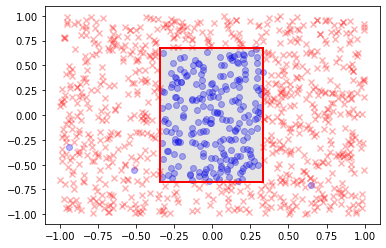

In [4]:
from matplotlib.patches import Rectangle

alpha = 0.2
n_core = int(n / 10)
X_core, Y_core = neighbor_core(X, Y, n_core)
beta_hat, min_eig, s_hat = core_fit(X_core, Y_core)
labels = hard_grow_labels(X, Y, alpha, std_in, min_eig, n_core, beta_hat)
R_hat = hard_grow_region(X[:, :-1], labels, B, center = np.mean(X_core[:, :-1], axis = 0))

fig, ax = plt.subplots()
ax.add_patch(Rectangle((R[0, 0], R[1, 0]), R[0, 1] - R[0, 0], R[1, 1] - R[1, 0],
                        alpha=0.1, facecolor='black'))
ax.add_patch(Rectangle((R_hat[0, 0], R_hat[1, 0]), R_hat[0, 1] - R_hat[0, 0], R_hat[1, 1] - R_hat[1, 0],
                        alpha=1, facecolor='none', edgecolor='red', linewidth=2.))
plt.scatter(X[labels == 0, 0], X[labels == 0, 1], marker='o', c='b', alpha = 0.3)
plt.scatter(X[labels == 1, 0], X[labels == 1, 1], marker='x', c='r', alpha = 0.3)


# With correct std

In [5]:
alpha = 0.2
n_core = int(n / 10)
num_trials = 50
num_centers = 20

core_B = np.array([[-1/6, 1/6], [-1/6, 1/6]])
offsets = np.linspace(0, 1/2, num_centers)

precs = np.zeros((num_trials, num_centers))
recs  = np.zeros((num_trials, num_centers))
F1s   = np.zeros((num_trials, num_centers))
for t in range(num_trials):
    for i, o in enumerate(offsets):
        X_core, Y_core = gen_data(n_core, d, std_in, std_out, beta, R, core_B + o)
        beta_hat, min_eig, s_hat = core_fit(X_core, Y_core)
        # print(beta, beta_hat)
        labels = hard_grow_labels(X, Y, alpha, std_in, min_eig, n_core, beta_hat)
        R_hat = hard_grow_region(X[:, :-1], labels, B, center = np.mean(X_core[:, :-1], axis = 0))

        p = box_intersection(R_hat, R) / box_intersection(R_hat, R_hat)
        r = box_intersection(R_hat, R) / box_intersection(R, R)
        f1 = (2 * p * r) / (p + r)
        precs[t, i] = p
        recs[t, i]  = r
        F1s[t, i]   = f1

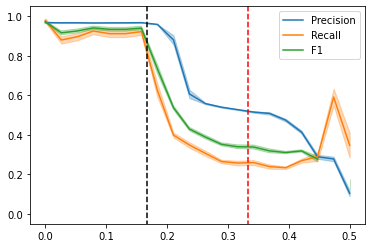

In [6]:
prec_mean = np.mean(precs, axis = 0)
prec_sem  = sem(precs, axis = 0)
rec_mean  = np.mean(recs, axis = 0)
rec_sem   = sem(recs, axis = 0)
F1_mean   = np.mean(F1s, axis = 0)
F1_sem    = sem(F1s, axis = 0)

fig, ax = plt.subplots()

line = plt.plot(offsets, prec_mean, label = 'Precision')
plt.fill_between(offsets, prec_mean + prec_sem, prec_mean - prec_sem, alpha = 0.3, color = line[0].get_color())

line = plt.plot(offsets, rec_mean, label = 'Recall')
plt.fill_between(offsets, rec_mean + rec_sem, rec_mean - rec_sem, alpha = 0.3, color = line[0].get_color())

line = plt.plot(offsets, F1_mean, label = 'F1')
plt.fill_between(offsets, F1_mean + F1_sem, F1_mean - F1_sem, alpha = 0.3, color = line[0].get_color())

plt.plot([1/3, 1/3], [-0.1, 1.1], c = 'r', linestyle = 'dashed')
plt.plot([1/6, 1/6], [-0.1, 1.1], c = 'black', linestyle = 'dashed')
ax.set_ylim(-0.05, 1.05)
plt.legend()

# With std estimated from core group

In [7]:
precs2 = np.zeros((num_trials, num_centers))
recs2  = np.zeros((num_trials, num_centers))
F1s2   = np.zeros((num_trials, num_centers))
for t in range(num_trials):
    for i, o in enumerate(offsets):
        X_core, Y_core = gen_data(n_core, d, std_in, std_out, beta, R, core_B + o)
        beta_hat, min_eig, s_hat = core_fit(X_core, Y_core)
        labels = hard_grow_labels(X, Y, alpha, s_hat, min_eig, n_core, beta_hat)
        R_hat = hard_grow_region(X[:, :-1], labels, B, center = np.mean(X_core[:, :-1], axis = 0))

        p = box_intersection(R_hat, R) / box_intersection(R_hat, R_hat)
        r = box_intersection(R_hat, R) / box_intersection(R, R)
        f1 = (2 * p * r) / (p + r)
        precs2[t, i] = p
        recs2[t, i]  = r
        F1s2[t, i]   = f1

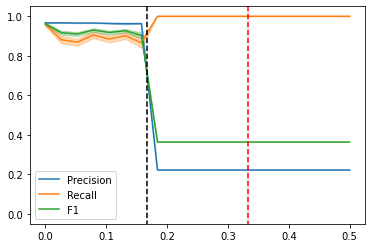

In [8]:
prec_mean2 = np.mean(precs2, axis = 0)
prec_sem2  = sem(precs2, axis = 0)
rec_mean2  = np.mean(recs2, axis = 0)
rec_sem2   = sem(recs2, axis = 0)
F1_mean2   = np.mean(F1s2, axis = 0)
F1_sem2    = sem(F1s2, axis = 0)

fig, ax = plt.subplots()

line = plt.plot(offsets, prec_mean2, label = 'Precision')
plt.fill_between(offsets, prec_mean2 + prec_sem2, prec_mean2 - prec_sem2, alpha = 0.3, color = line[0].get_color())

line = plt.plot(offsets, rec_mean2, label = 'Recall')
plt.fill_between(offsets, rec_mean2 + rec_sem2, rec_mean2 - rec_sem2, alpha = 0.3, color = line[0].get_color())

line = plt.plot(offsets, F1_mean2, label = 'F1')
plt.fill_between(offsets, F1_mean2 + F1_sem2, F1_mean2 - F1_sem2, alpha = 0.3, color = line[0].get_color())

plt.plot([1/3, 1/3], [-0.1, 1.1], c = 'r', linestyle = 'dashed')
plt.plot([1/6, 1/6], [-0.1, 1.1], c = 'black', linestyle = 'dashed')
ax.set_ylim(-0.05, 1.05)
plt.legend()

# With alternate cutoff

In [9]:
def hard_grow_cutoff(std, min_eig, n_core, n_full, alpha, x):
    d = len(x)
    # return std * (np.linalg.norm(x) * np.sqrt(d * np.log(4 * d / alpha) / n_core) / min_eig + np.sqrt(2 * np.log(4 * n_full / alpha)))
    return alpha * std * np.linalg.norm(x)

def hard_grow_labels(X, Y, alpha, std, min_eig, n_core, beta):
    n = len(Y)
    labels = np.zeros(n)
    for k in range(n):
        x = X[k]
        y = Y[k]
        if res(x, y, beta) > hard_grow_cutoff(std, min_eig, n_core, n, alpha, x):
            labels[k] = 1
    return labels

alpha = 5.

precs3 = np.zeros((num_trials, num_centers))
recs3  = np.zeros((num_trials, num_centers))
F1s3   = np.zeros((num_trials, num_centers))
for t in range(num_trials):
    for i, o in enumerate(offsets):
        X_core, Y_core = gen_data(n_core, d, std_in, std_out, beta, R, core_B + o)
        beta_hat, min_eig, s_hat = core_fit(X_core, Y_core)
        labels = hard_grow_labels(X, Y, alpha, s_hat, min_eig, n_core, beta_hat)
        R_hat = hard_grow_region(X[:, :-1], labels, B, center = np.mean(X_core[:, :-1], axis = 0))

        p = box_intersection(R_hat, R) / box_intersection(R_hat, R_hat)
        r = box_intersection(R_hat, R) / box_intersection(R, R)
        f1 = (2 * p * r) / (p + r)
        precs3[t, i] = p
        recs3[t, i]  = r
        F1s3[t, i]   = f1

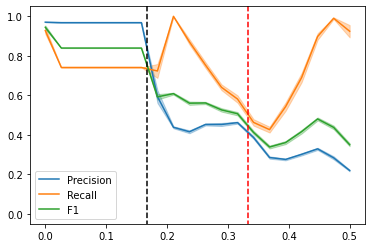

In [10]:
prec_mean3 = np.mean(precs3, axis = 0)
prec_sem3  = sem(precs3, axis = 0)
rec_mean3  = np.mean(recs3, axis = 0)
rec_sem3   = sem(recs3, axis = 0)
F1_mean3   = np.mean(F1s3, axis = 0)
F1_sem3    = sem(F1s3, axis = 0)

fig, ax = plt.subplots()

line = plt.plot(offsets, prec_mean3, label = 'Precision')
plt.fill_between(offsets, prec_mean3 + prec_sem3, prec_mean3 - prec_sem3, alpha = 0.3, color = line[0].get_color())

line = plt.plot(offsets, rec_mean3, label = 'Recall')
plt.fill_between(offsets, rec_mean3 + rec_sem3, rec_mean3 - rec_sem3, alpha = 0.3, color = line[0].get_color())

line = plt.plot(offsets, F1_mean3, label = 'F1')
plt.fill_between(offsets, F1_mean3 + F1_sem3, F1_mean3 - F1_sem3, alpha = 0.3, color = line[0].get_color())

plt.plot([1/3, 1/3], [-0.1, 1.1], c = 'r', linestyle = 'dashed')
plt.plot([1/6, 1/6], [-0.1, 1.1], c = 'black', linestyle = 'dashed')
ax.set_ylim(-0.05, 1.05)
plt.legend()

In [11]:
X_core, Y_core = gen_data(n_core, d, std_in, std_out, beta, R, core_B)
beta_hat, min_eig, s_hat = core_fit(X_core, Y_core)
labels = hard_grow_labels(X, Y, 0.2, s_hat, min_eig, n_core, beta_hat)
R_hat = hard_grow_region(X[:, :-1], labels, B, center = np.mean(X_core[:, :-1], axis = 0))

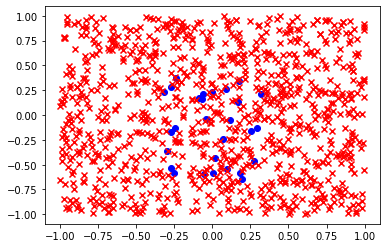

In [12]:
plt.scatter(X[labels == 0, 0], X[labels == 0, 1], marker='o', c='b')
plt.scatter(X[labels == 1, 0], X[labels == 1, 1], marker='x', c='r')